In [1]:
column = "rate"

In [2]:
import os

import numpy  as np

import matplotlib.pyplot as plt

from CCio   import load_hdf

from CCcore import filter_df
from CCcore import fix_hot_pixel
from CCcore import remove_duplicate_grating
from CCcore import rebin_df

from CCplot import change_jupyter_width
from CCplot import auto_plot_style
from CCplot import figure
from CCplot import subplot
from CCplot import plot1d
from CCplot import plot2d

In [3]:
exec(change_jupyter_width(90))

In [4]:
%matplotlib inline

auto_plot_style({"image.cmap" : "gnuplot2"})

In [46]:
#filenames = [ "/home/gonzalo/data/CC/Cf/scan_neutrons_irrad_LiF_B3_462_2022_02_24_12_36_12_912600.h5"
##            , "/home/gonzalo/data/CC/Cf/scan_neutrons_postanneal_LiF_B3_462_2022_03_01_12_10_30_709000.h5"
#            , "/home/gonzalo/data/CC/Cf/scan_neutrons_postanneal_LiF_B3_462_2022_03_02_12_06_53_415000.h5"
#            , "/home/gonzalo/data/CC/Cf/scan_neutrons_gamma_irrad_LiF_B3_462_2022_03_02_19_31_05_871000.h5"
#            ]

filenames = [ "/home/gonzalo/data/CC/Cf/scan_neutrons_irrad_MgF_B3_482_2022_02_28_15_53_38_787000.h5"
#            , "/home/gonzalo/data/CC/Cf/scan_neutrons_postanneal_MgF_B3_482_2022_03_01_13_40_19_086000.h5"
            , "/home/gonzalo/data/CC/Cf/scan_neutrons_postanneal_MgF_B3_482_2022_03_02_13_47_25_811000.h5"
            , "/home/gonzalo/data/CC/Cf/scan_neutrons_gamma_irrad_MgF_B3_482_2022_03_02_18_04_37_617000.h5"
            ]

#tags      = "irrad postanneal pregammma postgamma".split()
tags      = "irrad postanneal postgamma".split()
crystals  = [os.path.basename(filename).split("_")[-10] for filename in filenames]
datas     = [remove_duplicate_grating(load_hdf(filename, crystal)) for crystal, filename in zip(crystals, filenames)]
exposures = set()
for data in datas:
    exposures.update(sorted(data.exposure.drop_duplicates()))

nexposures = len(exposures)
ncrystals  = len(crystals)
numbers    = np.arange(ncrystals) + 1

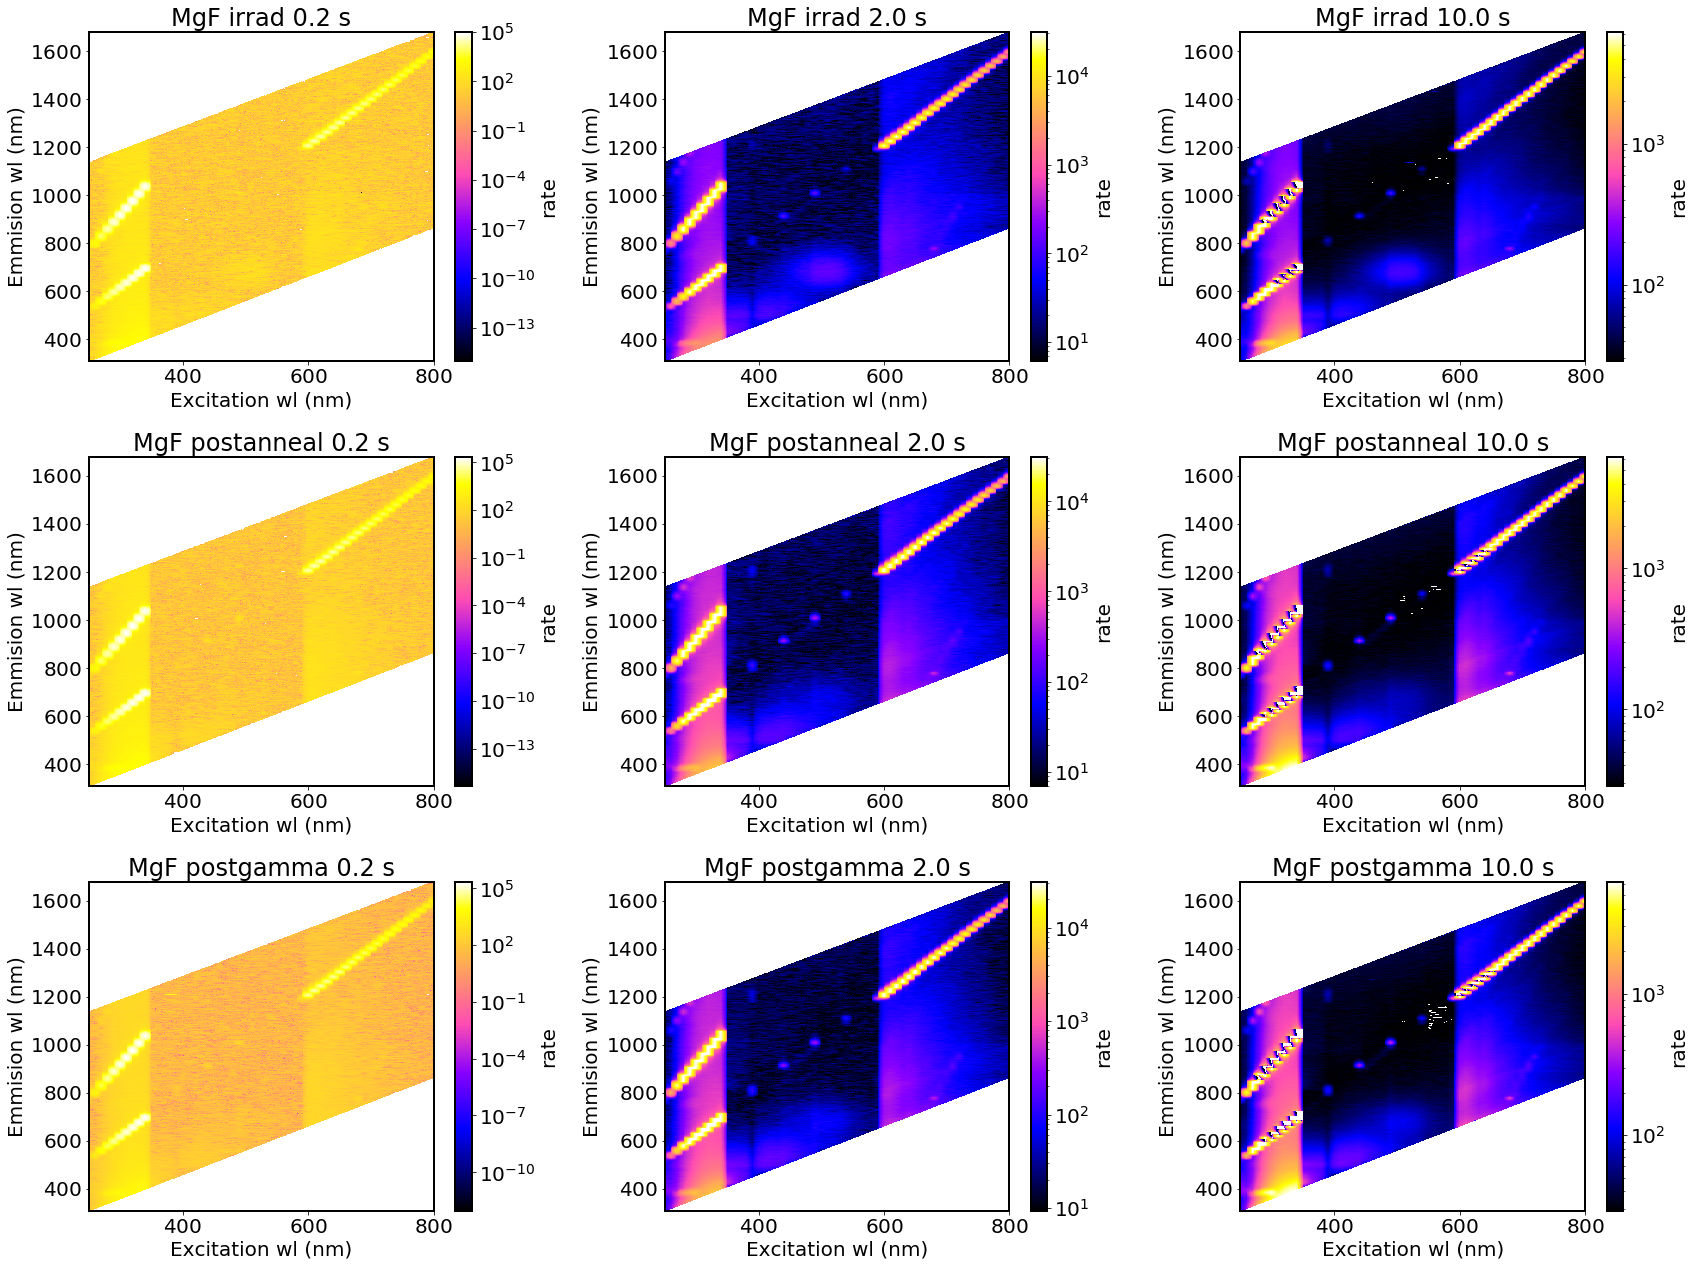

In [47]:
figure(nexposures * ncrystals)

k = 1
for crystal, tag, n, data in zip(crystals, tags, numbers, datas):
    for exposure in exposures:
        subplot(nexposures * ncrystals, k); k+= 1

        df       = filter_df(data, exposure=exposure)
        spectrum = df.loc[:, column]

        s, c = plot2d(df.ex_wl, df.em_wl, spectrum
                     , title  = f"{crystal} {tag} {exposure:.1f} s"
                     , log    = True
                     , zlabel = column
                     , cmin   = np.percentile(spectrum, 5)
                     , cmax   = spectrum.max()
                     )    

plt.tight_layout()

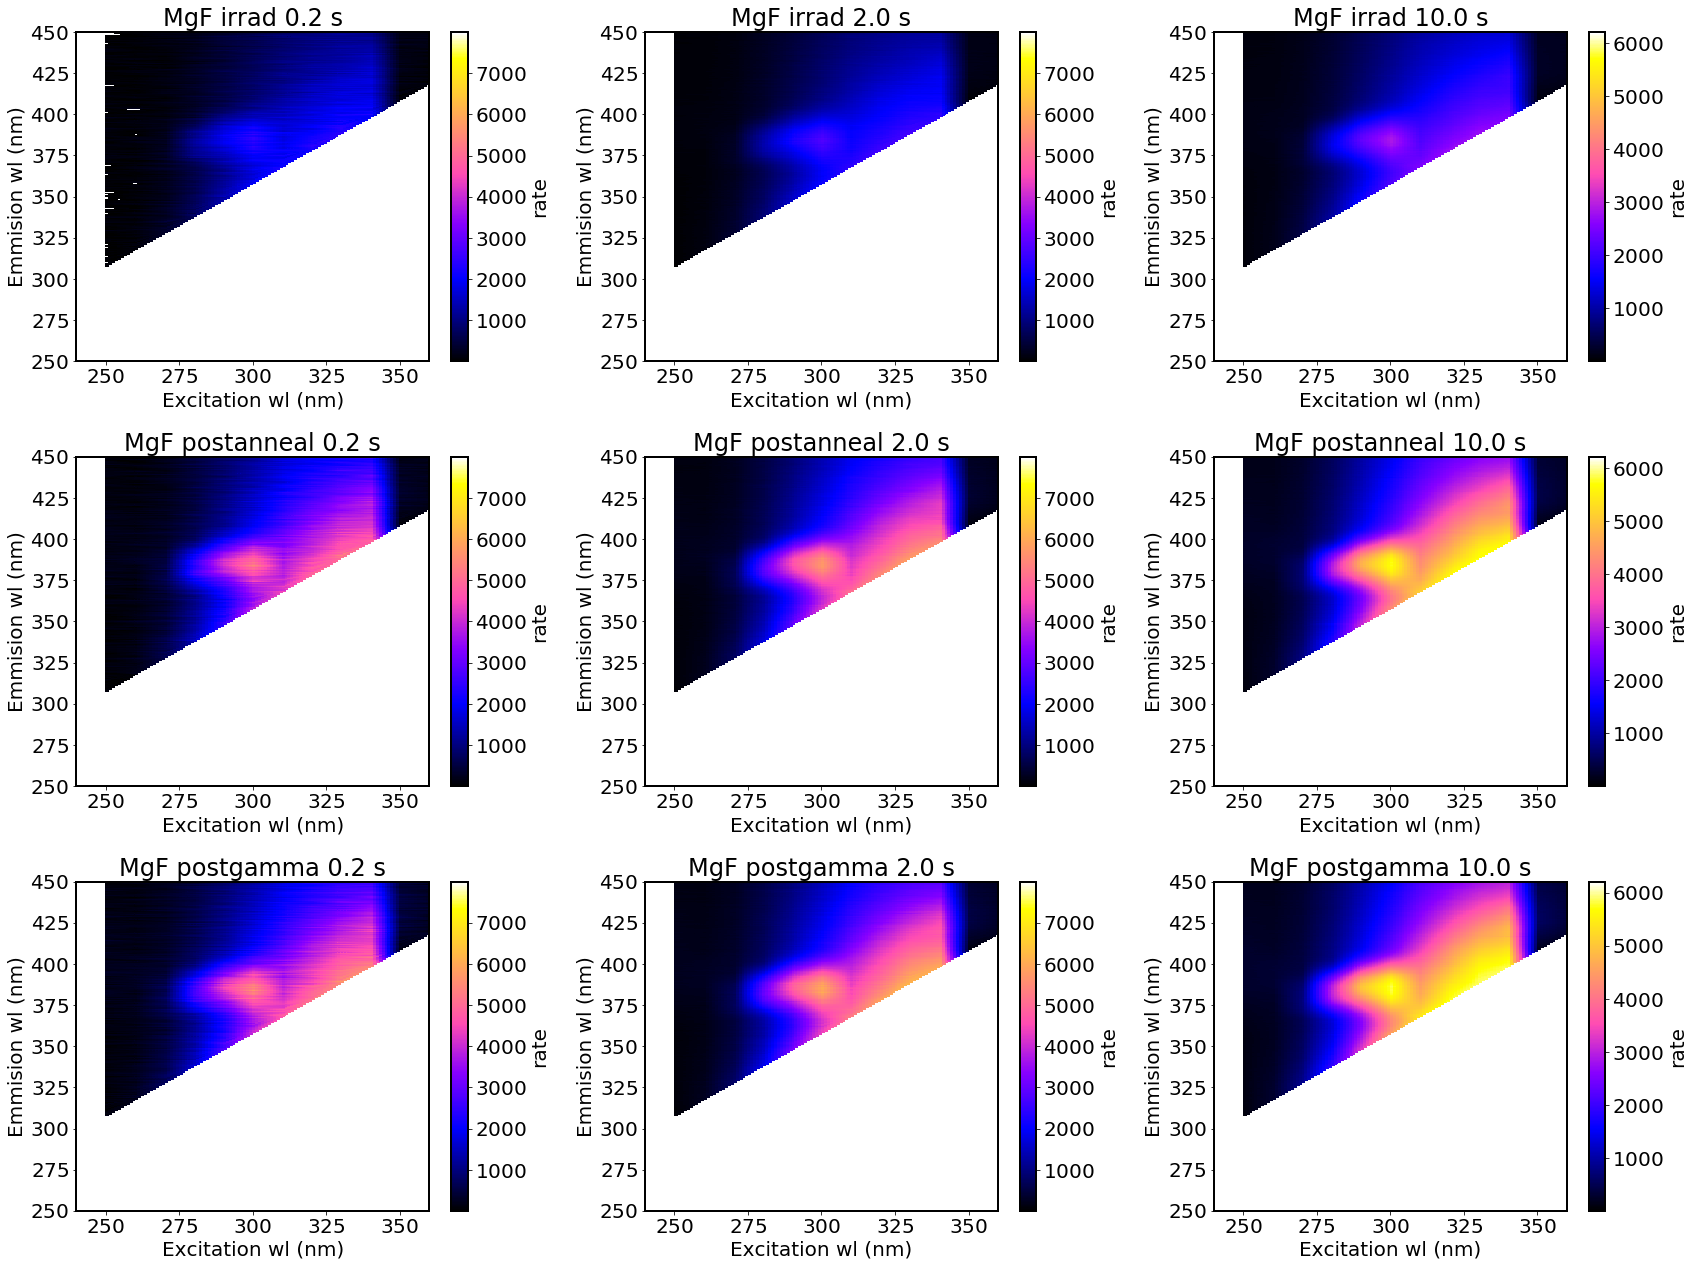

In [48]:
xmin, xmax = 240, 360
ymin, ymax = 250, 450
cmin, cmax =   5, 8e3

figure(nexposures * ncrystals)

k = 1
for crystal, tag, n, data in zip(crystals, tags, numbers, datas):
    for exposure in exposures:
        subplot(nexposures * ncrystals, k); k+= 1

        df       = filter_df(data, exposure=exposure)
        spectrum = df.loc[:, column]

        s, c = plot2d(df.ex_wl, df.em_wl, spectrum
                     , title  = f"{crystal} {tag} {exposure:.1f} s"
                     , log    = False
                     , zlabel = column
                     , cmin   = cmin
                     , cmax   = cmax
                     )
        plt.xlim(xmin, xmax)
        plt.ylim(ymin, ymax)

plt.tight_layout()

In [49]:
exposure = 10

plt.figure(figsize=(6*4, 3*14))
for crystal, tag, data in zip(crystals, tags, datas):
    data = filter_df(data, exposure=exposure)
    for ex_wl, df in data.groupby("ex_wl"):
        plt.subplot(14, 4, (ex_wl - 240) // 10)
        spectrum  = df.loc[:, column]
        plot1d(df.em_wl, spectrum, title=str(ex_wl), ylabel=column, label=f"{crystal} {tag}")

        plt.fill_betweenx(plt.ylim(), ex_wl - 10, ex_wl + 10, color="y", alpha=0.5)

        wlmin = np.floor(ex_wl/100) * 100
        wlmax = np.floor(df.em_wl.max()/100) * 100
        ticks = np.concatenate([ np.arange(wlmin, 1000, 200)
                               , np.arange(1000, wlmax, 200)])

        plt.xticks(ticks)
        plt.xlim(wlmin, wlmax)
        plt.ylim(-10, sorted(spectrum)[-3] *1.1)

        if ex_wl == 250 and tag == tags[-1]:
            plt.legend()

plt.tight_layout()

/home/gonzalo/sw/anaconda3/envs/CC/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


In [50]:
exposure = 2
ex_wl    = 250

xmin, xmax = 290, 720
ymin, ymax =   0, 300

for crystal, tag, data in zip(crystals, tags, datas):
    data = filter_df(data, exposure=exposure, ex_wl=ex_wl)
    spectrum  = data.loc[:, column]
    plot1d(data.em_wl, spectrum, title=str(ex_wl), ylabel=column, label=f"{tag}")

    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)

plt.legend()

In [7]:
def ticks(wls):
    min = np.ceil (wls.min() / 100) * 100
    max = np.floor(wls.max() / 100) * 100
    return np.arange(min, max + 1, 100)

In [14]:
exposure = 10
ex_wl    = 510
rebin    = 4
grating  = 1 + int(ex_wl >= 400)
df       = filter_df(data, exposure=exposure, ex_wl=ex_wl, grating_mono=grating)
df       = rebin_df(df, rebin)

plt.figure(figsize=(10, 8))
plot1d(df.em_wl, df.rate, ylabel="Rate (counts/s)")
plt.title(f"{ex_wl} nm, {exposure:.1f} s")
plt.grid()
plt.xticks(ticks(df.em_wl))
#plt.ylim(-5, 40)
#plt.legend()
pass

In [ ]:
# from 15:21 to 17:56
# = 2 h 35 min